In [1]:
from qiskit.quantum_info import SparsePauliOp
import numpy as np
from qiskit.synthesis import SuzukiTrotter
from qiskit.quantum_info import Statevector
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.converters import circuit_to_dag
from qiskit import transpile

from cutter_search_manual import *
from resource_analysis import PhysicalParameters


def get_hamiltonian(L, J, h, alpha=0):

    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    ZZ_tuples = [("ZZ", [i, i + 1], -J) for i in range(0, L - 1)]
    Z_tuples = [("Z", [i], -h * np.sin(alpha)) for i in range(0, L)]
    X_tuples = [("X", [i], -h * np.cos(alpha)) for i in range(0, L)]

    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *Z_tuples, *X_tuples], num_qubits=L)
    return hamiltonian.simplify()


Trotter step with Suzuki Trotter (2nd order)
--------------------------------------------

                  Depth: 15
             Gate count: 21
    Nonlocal gate count: 8
         Gate breakdown: RZ: 10, CX: 8, RY: 2, RX: 1


SparsePauliOp(['IZZ', 'ZZI', 'IIZ', 'IZI', 'ZII', 'IIX', 'IXI', 'XII'],
              coeffs=[-0.2       +0.j, -0.2       +0.j, -0.38268343+0.j, -0.38268343+0.j,
 -0.38268343+0.j, -0.92387953+0.j, -0.92387953+0.j, -0.92387953+0.j])


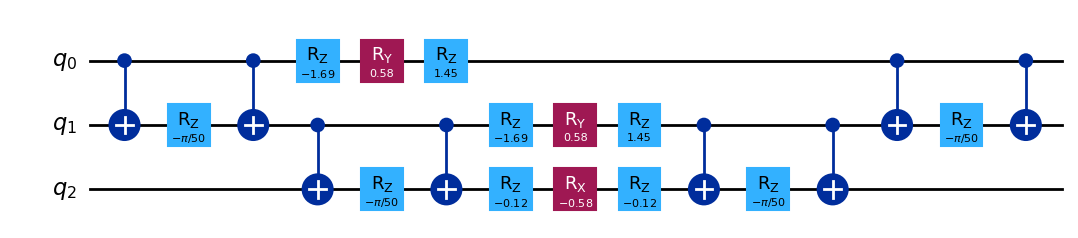

In [2]:
second_order_formula = SuzukiTrotter()

L = 3
H = get_hamiltonian(L=L, J=0.2, h=1.0, alpha=np.pi / 8)
final_time = np.pi
num_timesteps = 10
dt = final_time / num_timesteps
initial_state = Statevector.from_label("000")

trotter_step_second_order = PauliEvolutionGate(H, dt, synthesis=second_order_formula)
circuit = QuantumCircuit(H.num_qubits)
for i in range(1):
    circuit.append(trotter_step_second_order, range(H.num_qubits))
# circuit = circuit.decompose(reps=1)
target_basis = ['rx', 'ry', 'rz', 'h', 'cx']
circuit = transpile(circuit,
                       basis_gates=target_basis, 
                       optimization_level=1) 

# Let us print some stats
print(
    f"""
Trotter step with Suzuki Trotter (2nd order)
--------------------------------------------

                  Depth: {circuit.depth()}
             Gate count: {len(circuit)}
    Nonlocal gate count: {circuit.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}

"""
)
print(H)

circuit.draw("mpl")

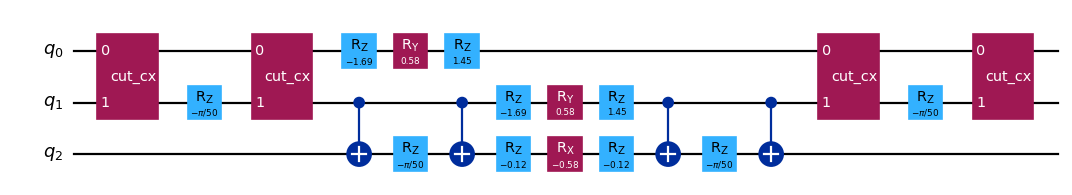

In [6]:
from circuit_knitting.cutting import cut_gates

# Find the indices of the distant gates
cut_indices = [
    i
    for i, instruction in enumerate(circuit.data)
    if {circuit.find_bit(q)[0] for q in instruction.qubits} == {0, 1}
]

# Decompose distant CNOTs into TwoQubitQPDGate instances
qpd_circuit, bases = cut_gates(circuit, cut_indices)

qpd_circuit.draw("mpl", scale=0.8)

In [11]:
import numpy as np
from circuit_knitting.cutting import generate_cutting_experiments

# Generate the subexperiments and sampling coefficients
subexperiments, coefficients = generate_cutting_experiments(
    circuits=qpd_circuit, observables=observable.paulis, num_samples=np.inf
)

In [12]:
print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")

Sampling overhead: 6561.0


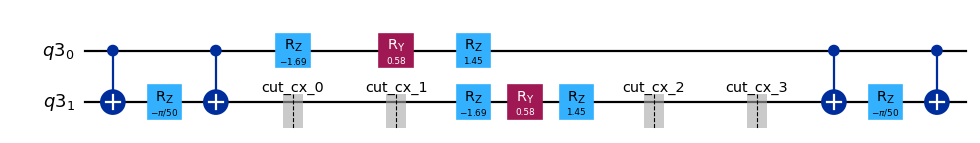

In [5]:
print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")

In [3]:
# DAG = circuit_to_dag(circuit)
# DAG.draw(scale=0.7)

In [4]:
# stripped_circ = circuit_stripping(circuit=circuit)
# n_vertices, gedges, wedges, node_name_ids, id_node_names = read_circ(circuit=stripped_circ)
# node_name_ids

In [5]:
find_cuts(circuit,    
[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]],
[[('q[1]9', 'q[2]8')], [('q[0]1', 'q[1]3'), ('q[1]9', 'q[0]5')]]
)

                            ┌────────────┐┌─────────────┐┌────────────┐»
q_0: ──■─────────────────■──┤ Rz(-1.691) ├┤ Ry(0.58049) ├┤ Rz(1.4506) ├»
     ┌─┴─┐┌───────────┐┌─┴─┐└─┬───────┬──┘└──┬───────┬──┘└────────────┘»
q_1: ┤ X ├┤ Rz(-π/50) ├┤ X ├──┤ Meas0 ├──────┤ Init0 ├─────────■───────»
     └───┘└───────────┘└───┘  └───────┘      └───────┘       ┌─┴─┐     »
q_2: ────────────────────────────────────────────────────────┤ X ├─────»
                                                             └───┘     »
«                                                                       »
«q_0: ──────────────────────────────────────────────────────────────────»
«                        ┌────────────┐ ┌─────────────┐  ┌────────────┐ »
«q_1: ───────────────■───┤ Rz(-1.691) ├─┤ Ry(0.58049) ├──┤ Rz(1.4506) ├─»
«     ┌───────────┐┌─┴─┐┌┴────────────┴┐├─────────────┴┐┌┴────────────┴┐»
«q_2: ┤ Rz(-π/50) ├┤ X ├┤ Rz(-0.12022) ├┤ Rx(-0.58049) ├┤ Rz(-0.12022) ├»
«     └───────────┘└───┘└──────────────┘└────